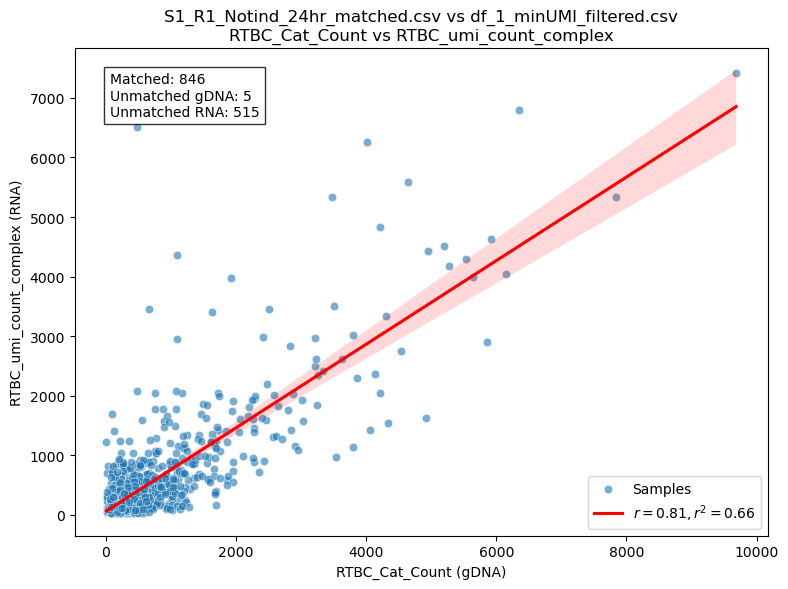

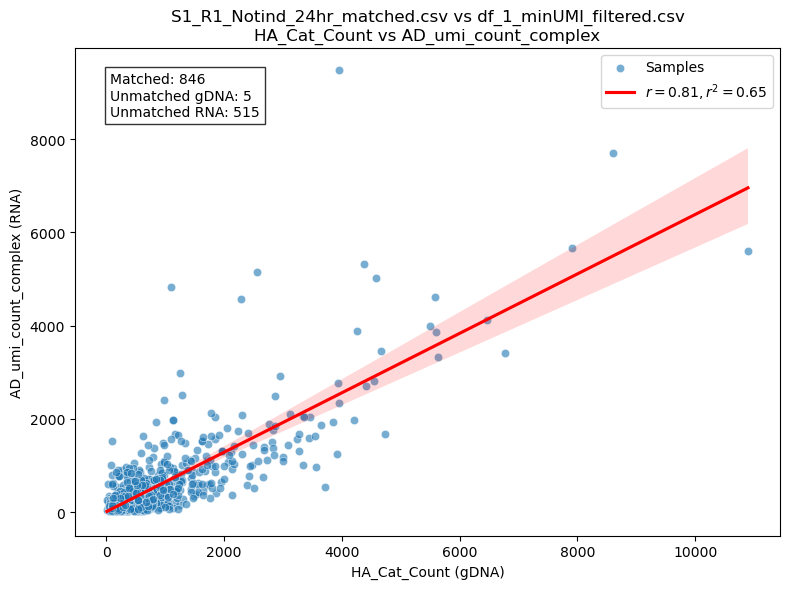

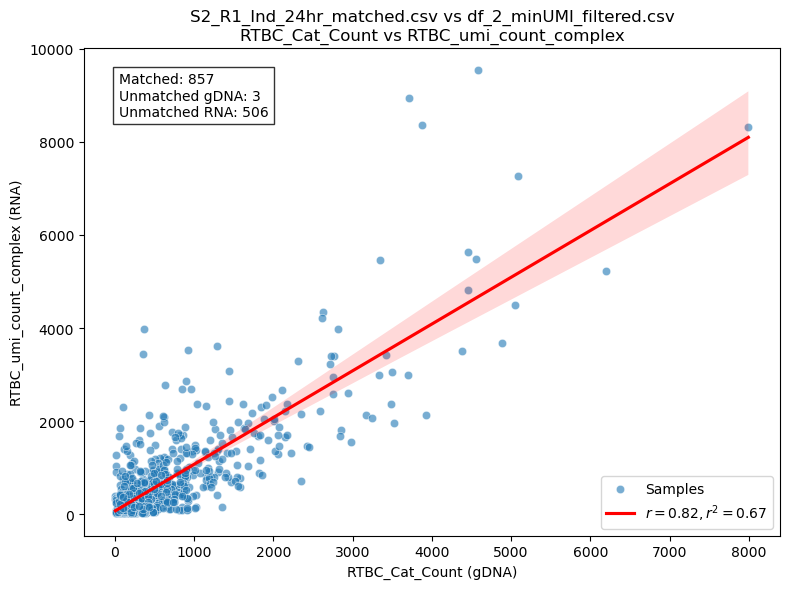

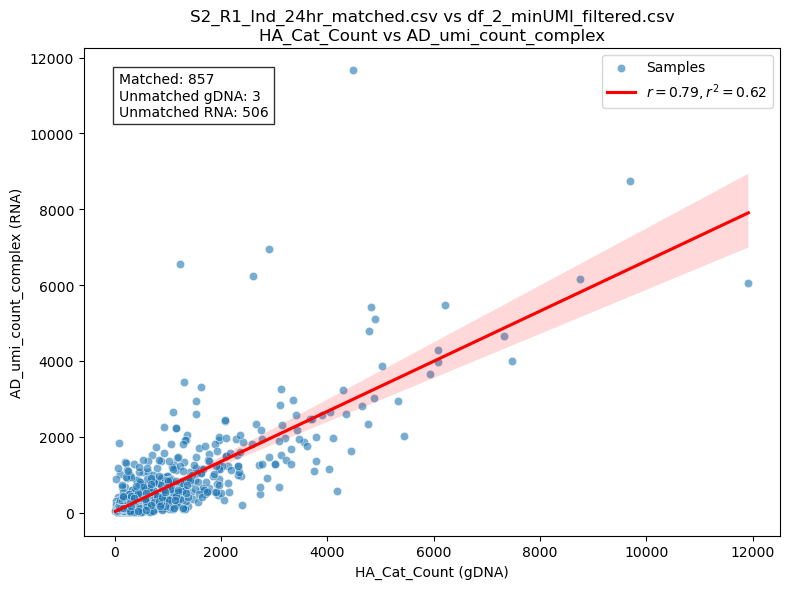

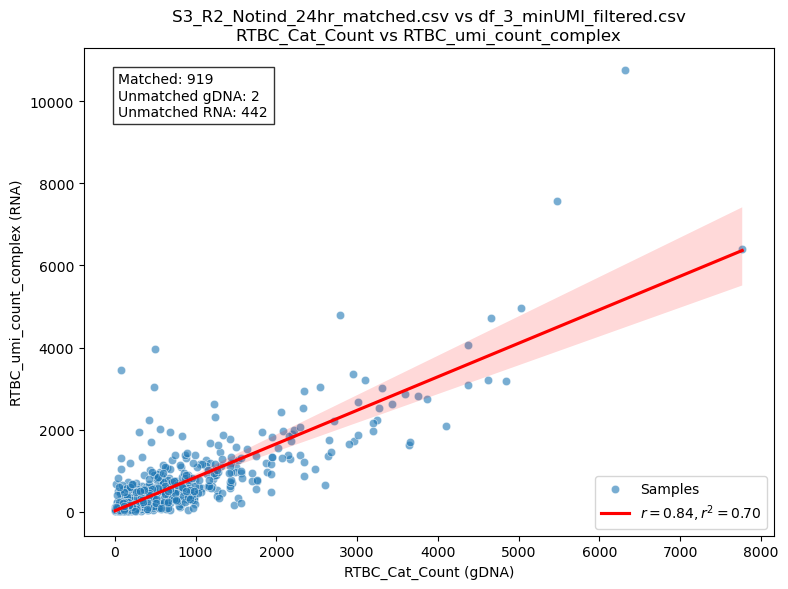

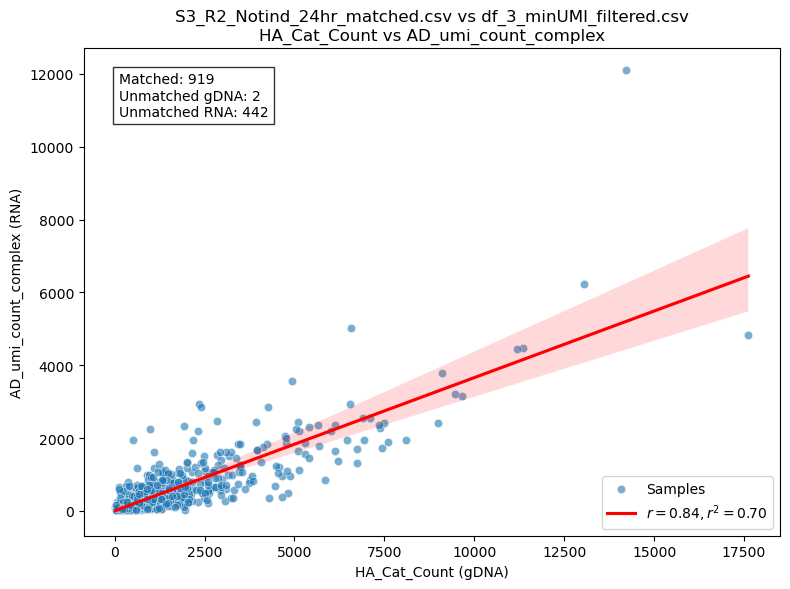

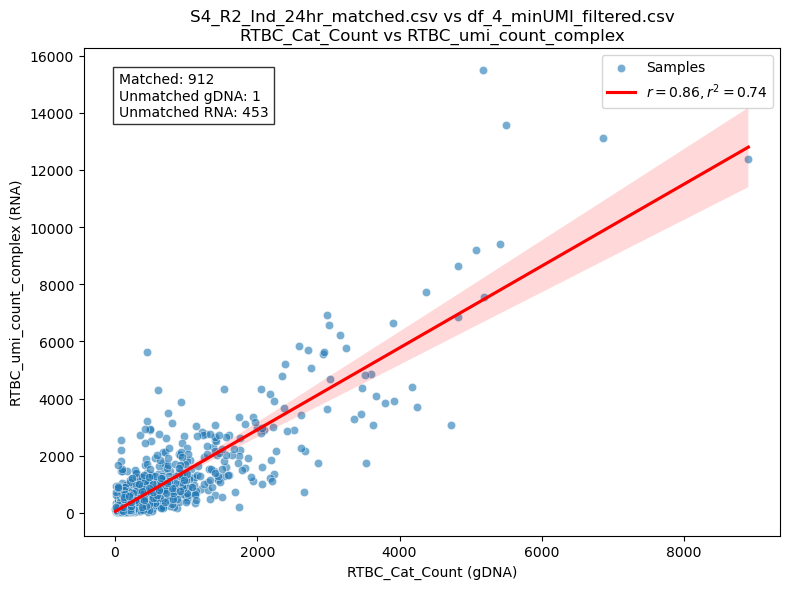

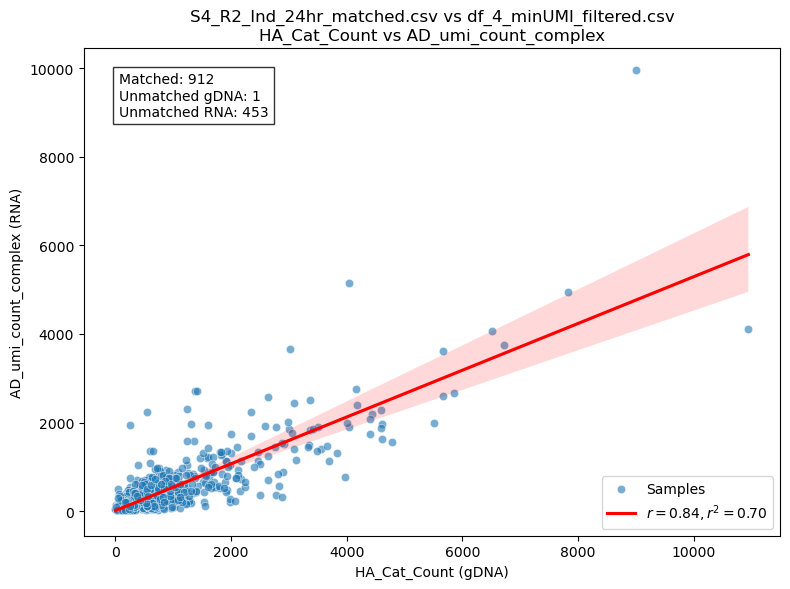

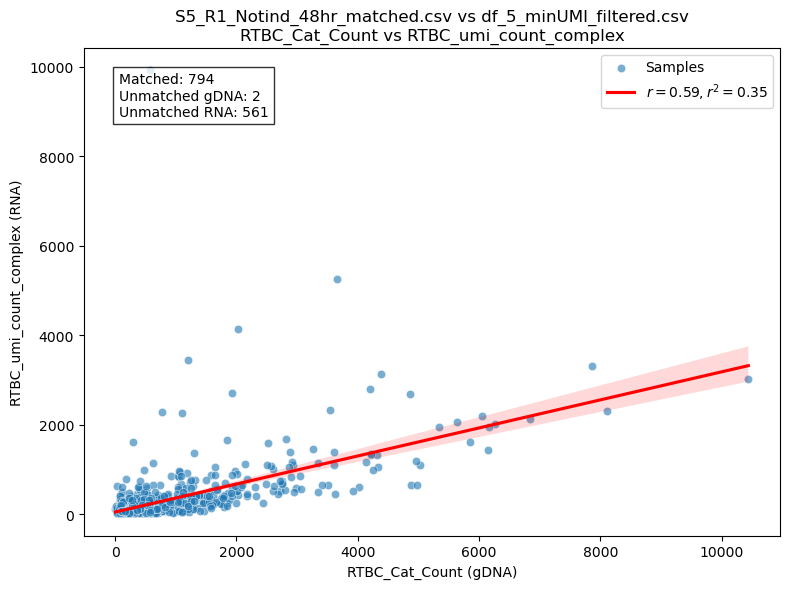

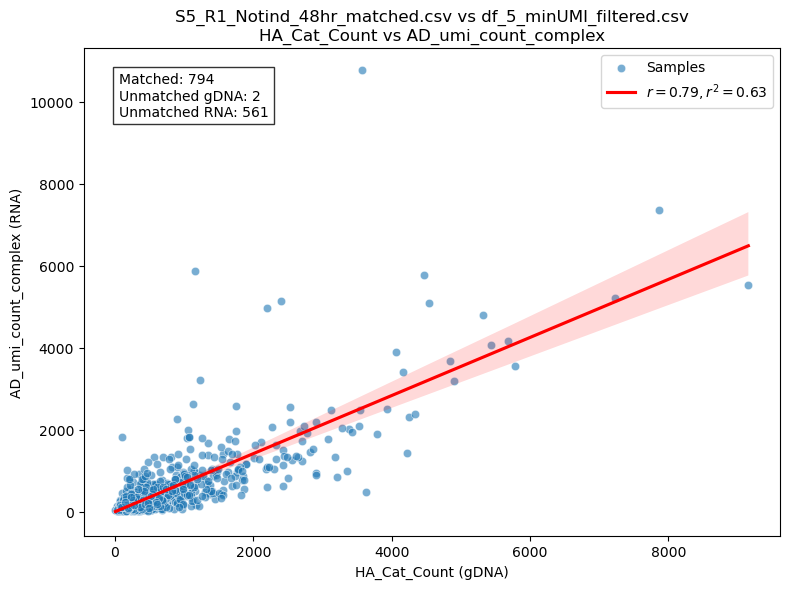

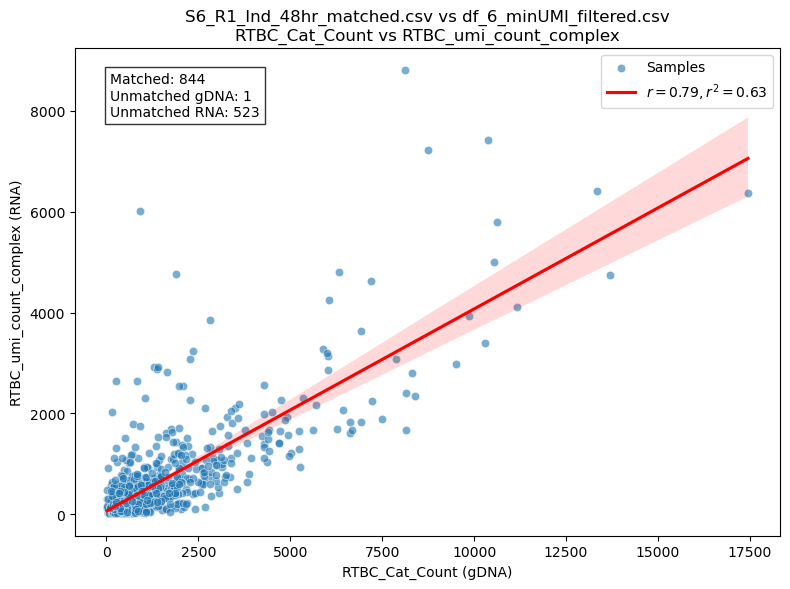

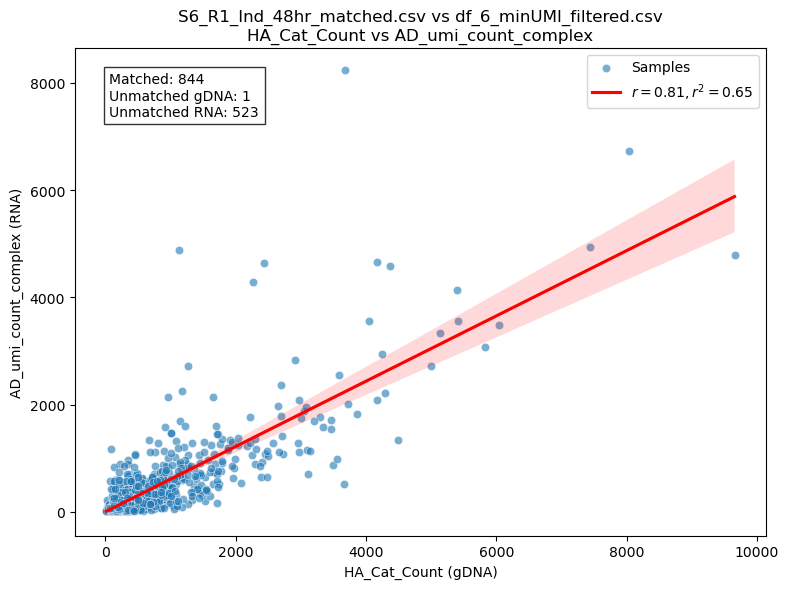

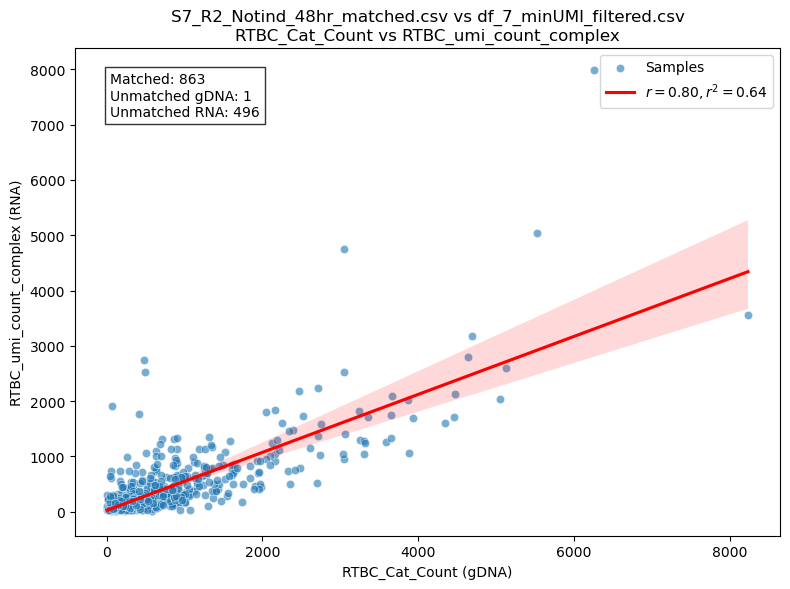

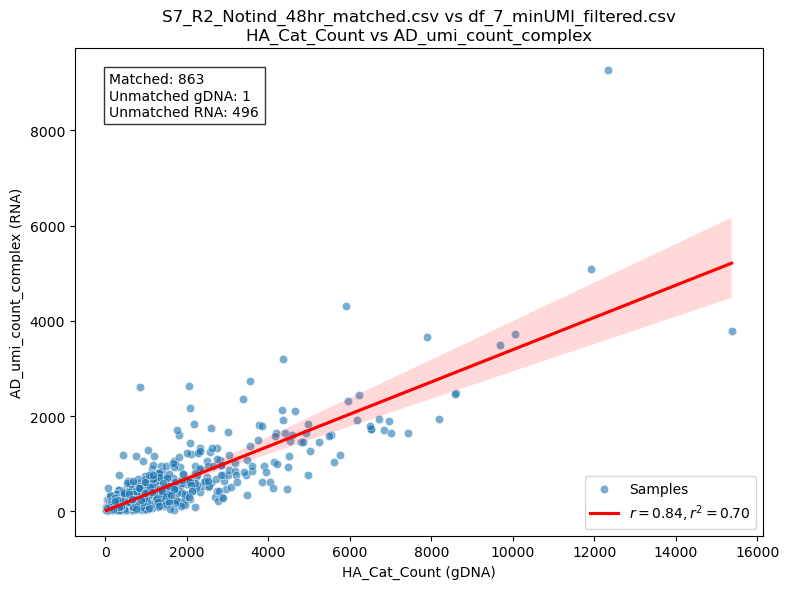

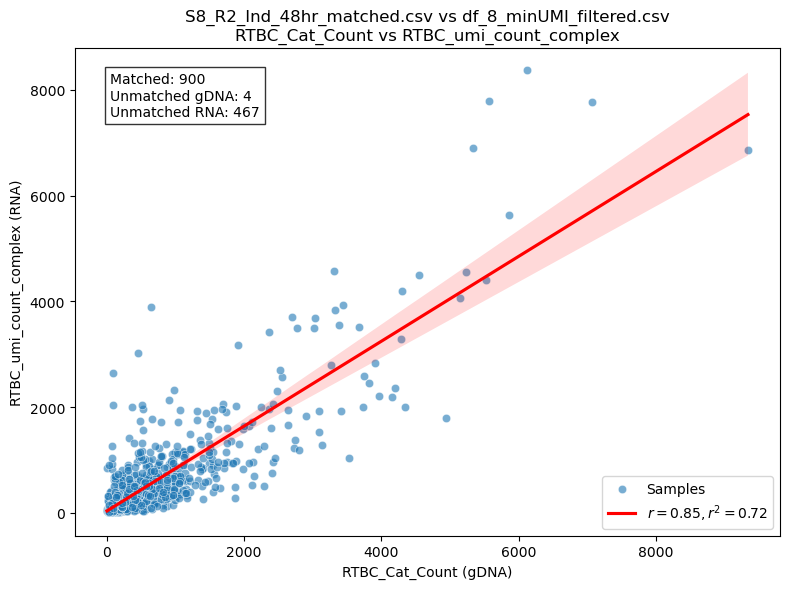

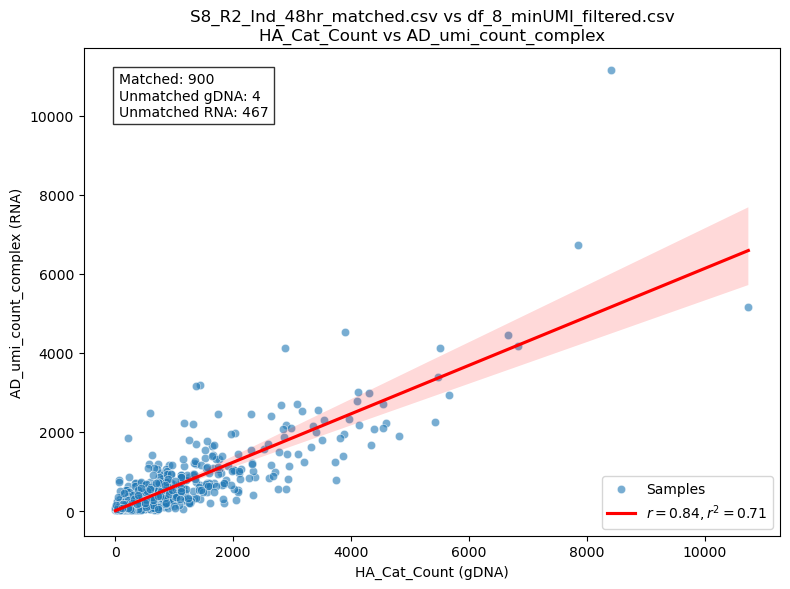

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set up paths
gdna_folder = 'matched_gDNA'
rna_folder = 'min_UMI_filtered_dfs'
output_folder = 'gDNA_vs_RNA_plots_12_2_25_matched_gDNA_filteredUMI'
os.makedirs(output_folder, exist_ok=True)

# Get sorted list of files
gdna_files = sorted([f for f in os.listdir(gdna_folder) if f.endswith('.csv')])
rna_files = sorted([f for f in os.listdir(rna_folder) if f.endswith('.csv')])

# Sanity check
assert len(gdna_files) == len(rna_files), "Mismatch in number of files between gDNA and RNA folders."

# Column pairs to compare
column_pairs = [
    ('RTBC_Cat_Count', 'RTBC_umi_count_complex'), #UPDATE with column names first in tulpe is gDNA read count second is RNA UMI count
    ('HA_Cat_Count', 'AD_umi_count_complex')
]

# Loop through each file pair
for i, (gdna_file, rna_file) in enumerate(zip(gdna_files, rna_files)):
    gdna_path = os.path.join(gdna_folder, gdna_file)
    rna_path = os.path.join(rna_folder, rna_file)

    gdna_df = pd.read_csv(gdna_path)
    rna_df = pd.read_csv(rna_path)

    # Merge on index (or modify to merge on a shared key if needed)
    merged = pd.merge(gdna_df,rna_df,on='Cat',how='outer', suffixes=('_gDNA', '_RNA')) #UPDATE on='Cat' if you want a different value to match on 

    for col_gdna, col_rna in column_pairs:
        x = merged[col_gdna]
        y = merged[col_rna]

        # Drop NaNs for correlation
        valid = merged[[col_gdna, col_rna]].dropna()
        r, _ = pearsonr(valid[col_gdna], valid[col_rna])
        r2 = r ** 2

        matched = len(valid)
        unmatched_gdna = merged[col_gdna].isna().sum()
        unmatched_rna = merged[col_rna].isna().sum()

        # Plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=col_gdna, y=col_rna, data=valid, alpha=0.6, label='Samples')
        sns.regplot(
            x=col_gdna,
            y=col_rna,
            data=valid,
            scatter=False,
            color='red',
            label=f'$r={r:.2f}, r^2={r2:.2f}$' )
        plt.legend()
        plt.title(f'{gdna_file} vs {rna_file}\n{col_gdna} vs {col_rna}')
        plt.xlabel(f'{col_gdna} (gDNA)')
        plt.ylabel(f'{col_rna} (RNA)')
        plt.text(0.05, 0.95, f'Matched: {matched}\nUnmatched gDNA: {unmatched_gdna}\nUnmatched RNA: {unmatched_rna}',
                 transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

        # Save plot
        plot_filename = f'{os.path.splitext(gdna_file)[0]}_{col_gdna}_vs_{col_rna}.png'
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, plot_filename))
        plt.show()
